<a href="https://colab.research.google.com/github/aasyngier/machine-learning/blob/main/ml_homework10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment – Adversarial Examples**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited

Re-run the input optimization process (for NN dreams) from the previous MLP-class homework assignment, but this time using the **LeNet-5 CNN model** we trained in this class.


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.



## Deliverables for the Homework Assignment
- A Google Colab notebook with:
  - Complete implementation for both tasks.
  - Visualizations and animations (animations are optional but encouraged).
  - Clear written analysis of your findings.
- Upload the notebook and results to your GitHub repository for the course.
- Include a link to the notebook and video (if applicable) in the `README.md`.
- In the notebook, include “Open in Colab” badge so it can be launched directly.

In [20]:
import torch, torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import numpy as np, random, imageio, pathlib, time

SEED   = 0
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
print("device:", device)

device: cuda


In [21]:
BATCH = 128
mean, std = 0.1307, 0.3081

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std]),
])

trainset = torchvision.datasets.MNIST(root='.', train=True , download=True, transform=transform)
testset  = torchvision.datasets.MNIST(root='.', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=BATCH, shuffle=True , num_workers=2, pin_memory=True)
testloader  = DataLoader(testset , batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

In [22]:
import torch.nn as nn

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Sigmoid(),
            nn.AvgPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

net = LeNet5().to(device)

In [23]:
TRAIN_EPOCHS = 5
LR            = 1e-3
CKPT_PATH     = "lenet_mnist.pt"

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LR)

def evaluate(loader):
    net.eval(); hit,total = 0,0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            hit  += (net(x).argmax(1)==y).sum().item()
            total+= y.size(0)
    return hit/total

if TRAIN_EPOCHS>0:
    for ep in range(TRAIN_EPOCHS):
        net.train()
        pbar = tqdm(trainloader, desc=f"Epoch {ep+1}/{TRAIN_EPOCHS}")
        for xb,yb in pbar:
            xb,yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(net(xb), yb)
            loss.backward(); optimizer.step()
            pbar.set_postfix(loss=loss.item())
        print("val acc:", evaluate(testloader))
    torch.save(net.state_dict(), CKPT_PATH)
    print("weights saved to", CKPT_PATH)
else:
    net.load_state_dict(torch.load(CKPT_PATH, map_location=device))
    print("weights loaded from", CKPT_PATH, "· test acc:", evaluate(testloader))

Epoch 1/5: 100%|██████████| 469/469 [00:13<00:00, 34.23it/s, loss=0.525]


val acc: 0.87


Epoch 2/5: 100%|██████████| 469/469 [00:14<00:00, 32.11it/s, loss=0.233]


val acc: 0.9319


Epoch 3/5: 100%|██████████| 469/469 [00:14<00:00, 32.89it/s, loss=0.0874]


val acc: 0.9495


Epoch 4/5: 100%|██████████| 469/469 [00:13<00:00, 34.13it/s, loss=0.0449]


val acc: 0.9617


Epoch 5/5: 100%|██████████| 469/469 [00:13<00:00, 33.87it/s, loss=0.133]


val acc: 0.9672
weights saved to lenet_mnist.pt


In [28]:
def un_norm(t):
    return torch.clamp(t * std + mean, 0., 1.)

def show_grid(imgs, ncol=10, title=""):
    rows = (len(imgs)+ncol-1)//ncol
    plt.figure(figsize=(1.2*ncol,1.2*rows))
    for i,im in enumerate(imgs):
        plt.subplot(rows, ncol, i+1); plt.axis('off')
        plt.imshow(im.squeeze(), cmap='gray')
    plt.suptitle(title); plt.show()

## Task 1 – CNN Dreams  

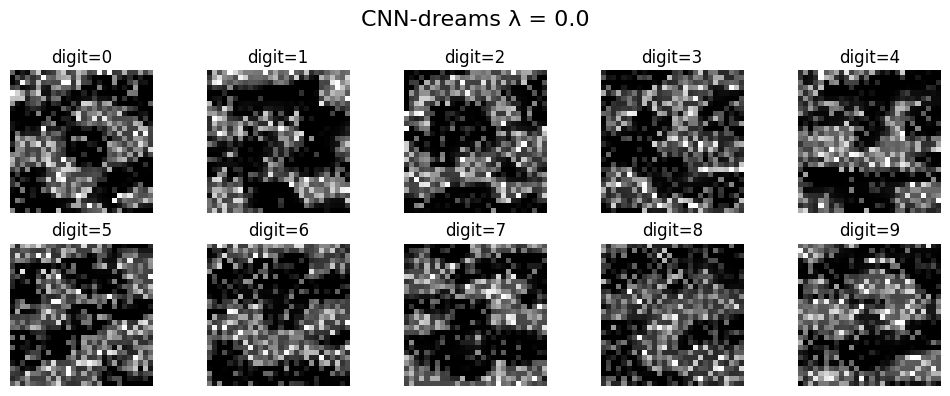

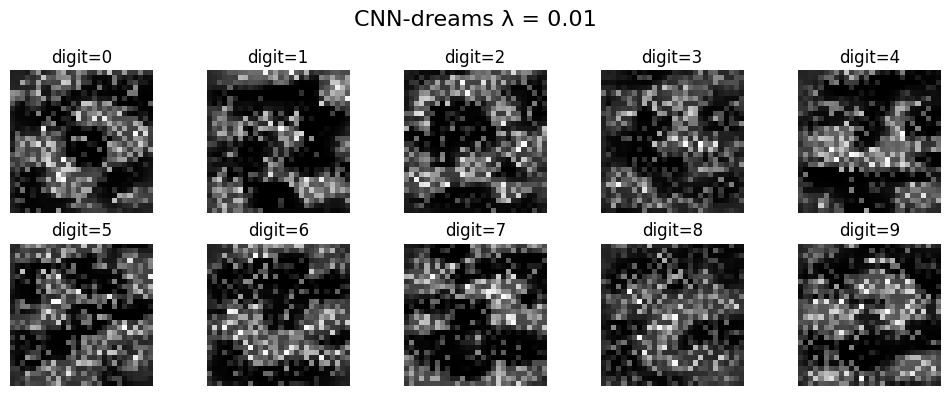

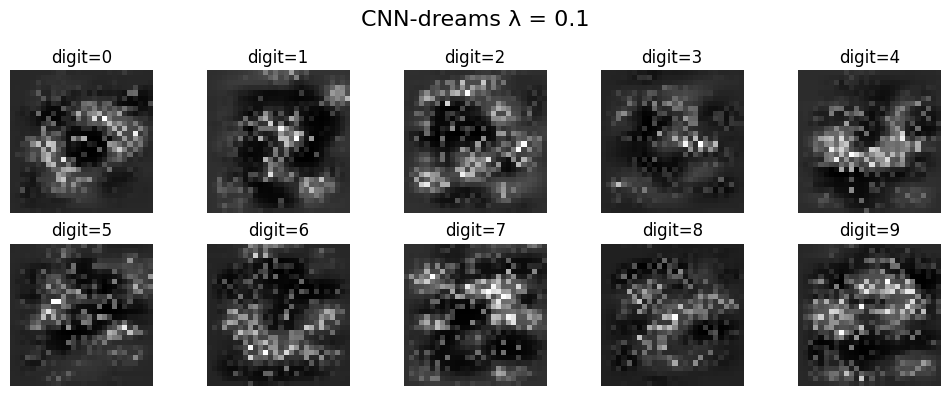

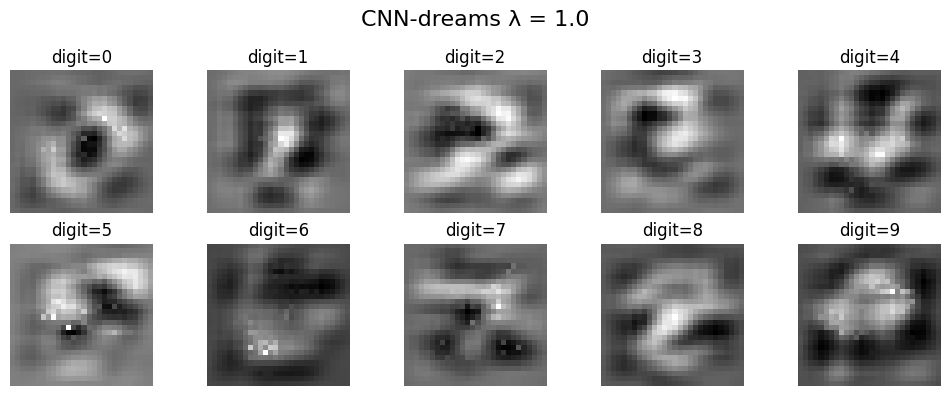

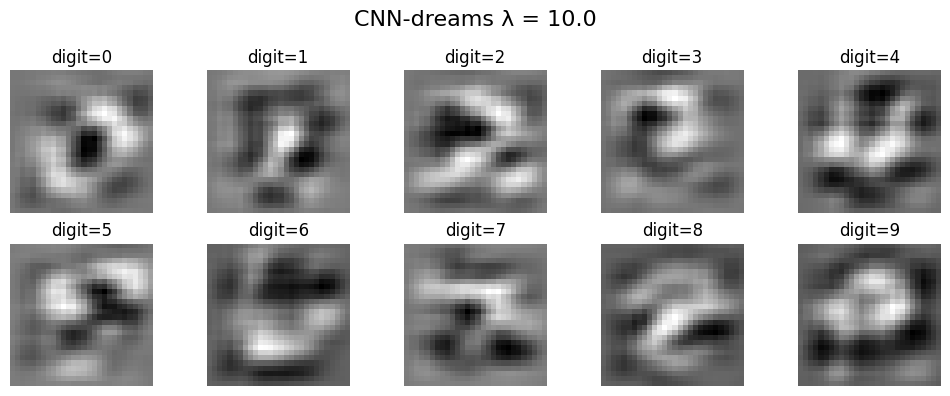

In [29]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

net.eval()
for p in net.parameters():
    p.requires_grad_(False)

std, mean = 0.3081, 0.1307
unnorm = lambda x: (x * std + mean).clamp(0, 1)

lr, steps              = 0.1, 300
l2_list                = [0.0, 0.01, 0.1, 1.0, 10.0]
initial_noise          = torch.randn(10,1,28,28, device=device)
targets                = torch.arange(10, device=device)

for λ in l2_list:
    digits = initial_noise.clone().detach().requires_grad_(True)
    opt    = torch.optim.Adam([digits], lr=lr)

    for _ in range(steps):
        opt.zero_grad()
        logits   = net(digits)
        ce_loss  = F.cross_entropy(logits, targets)
        l2_loss  = λ * digits.pow(2).mean()
        (ce_loss + l2_loss).backward()
        opt.step()
        with torch.no_grad():
            lo, hi = (0-mean)/std, (1-mean)/std
            digits.clamp_(lo, hi)

    final_un = unnorm(digits).detach().cpu().numpy()

    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(final_un[i, 0], cmap='gray')
        ax.set_title(f"digit={i}")
        ax.axis('off')
    fig.suptitle(f"CNN‐dreams λ = {λ}", fontsize=16)
    plt.tight_layout()
    plt.show()

The CNN “dreams” are much easier to read than the MLP’s. With zero L₂ penalty, the CNN outputs already form rough loops and straight lines, while the MLP without penalty is just noisy static. When you add a little L₂ penalty (around 0.1), the CNN images become much clearer digits—perfect circles for “0”s, straight bars for “1”s—whereas the MLP only starts to look digit-like if you crank its penalty way up. This difference comes down to architecture: a CNN applies the same small edge-detector across the whole image and then pools those results, so it naturally produces strokes and shapes. An MLP treats each pixel independently, with no concept of local structure, so it ends up with blotchy patterns.

## Task 2 – Targeted Adversarial Examples

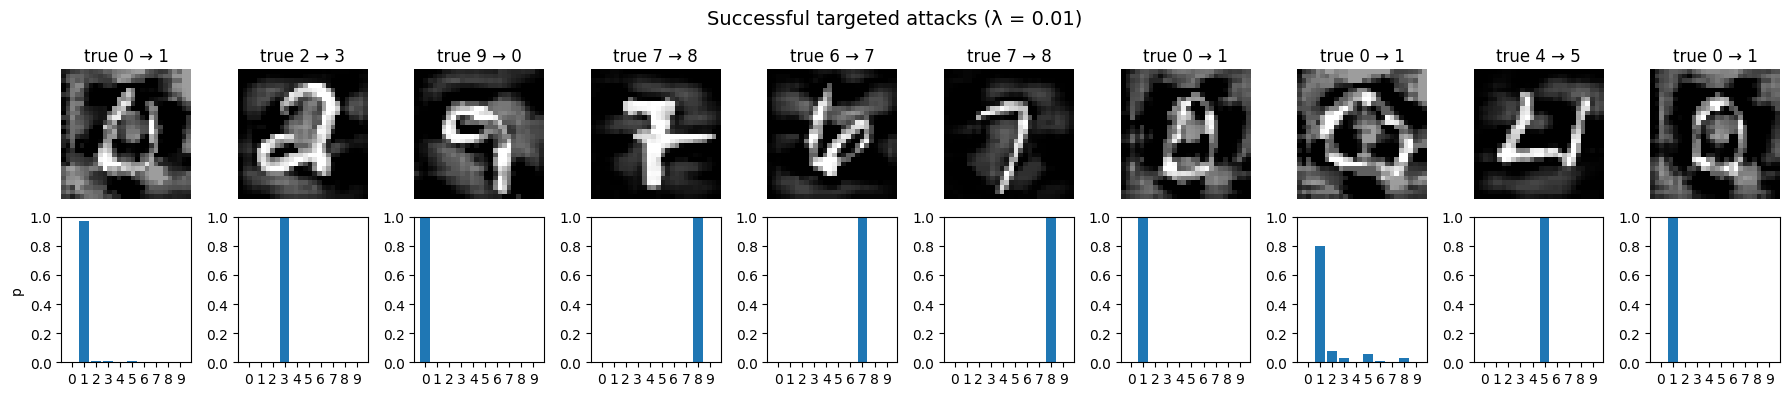

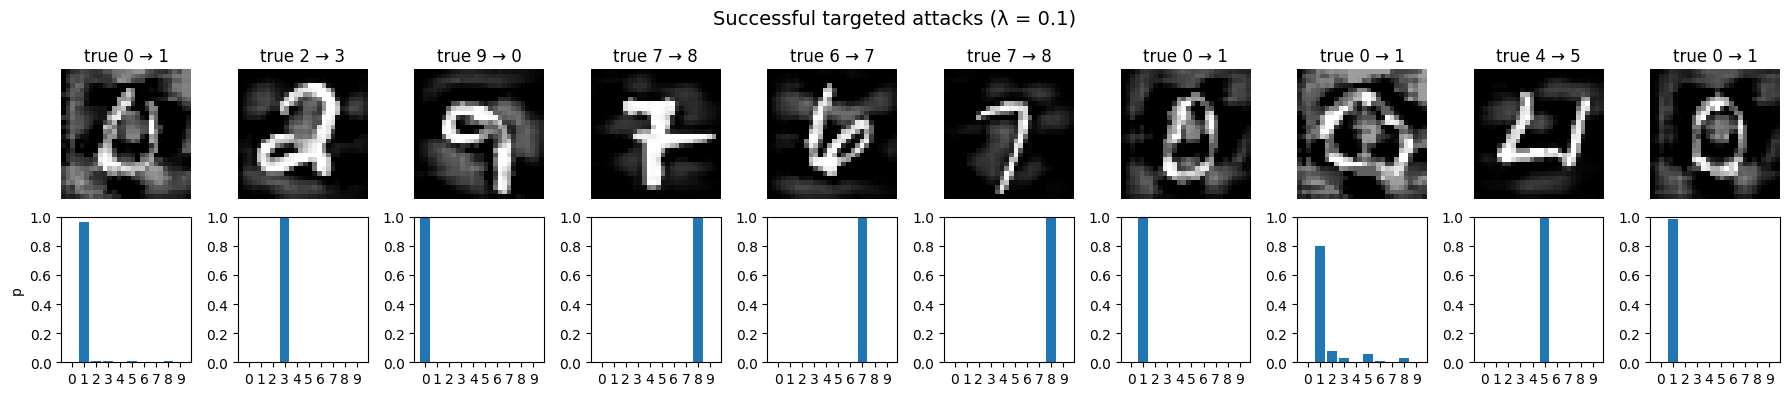

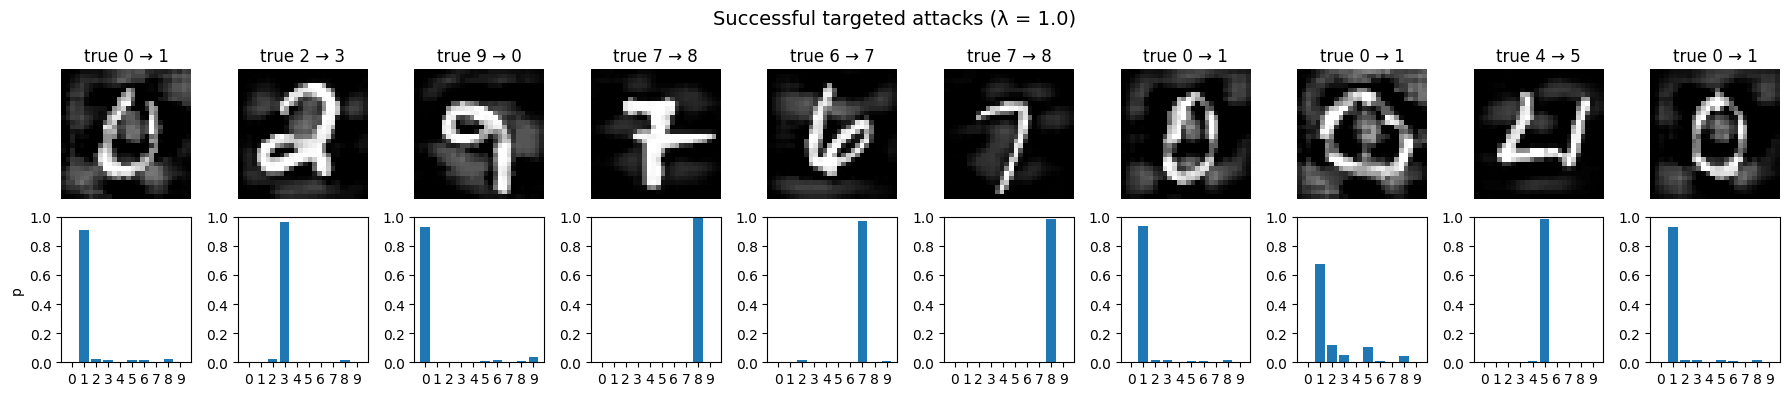

Overall success-rate per λ


,lambda,successes,attempts,success_rate (%)
0,0.010000,495,500,99.0
1,0.100000,495,500,99.0
2,1.000000,495,500,99.0



Successful attacks per *true* digit


,0.01,0.10,1.00
digit,,,
0,45,45,45
1,50,50,50
2,50,50,50
3,50,50,50
4,50,50,50
5,50,50,50
6,50,50,50
7,50,50,50
8,50,50,50


In [43]:
import torch, torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import numpy as np
import pandas as pd
from collections import defaultdict

device = next(net.parameters()).device

BATCH          = 128
l2_list        = [0.01, 0.1, 1.0]
steps          = 100
lr             = 0.02
n_per_digit    = 50

mean, std = 0.1307, 0.3081
unnorm = lambda x: (x * std + mean).clamp(0, 1)

indices_by_lbl = {d: [] for d in range(10)}
for idx, (_, lbl) in enumerate(testset):
    if len(indices_by_lbl[lbl]) < n_per_digit:
        indices_by_lbl[lbl].append(idx)
    if all(len(v) == n_per_digit for v in indices_by_lbl.values()):
        break

sub_indices = sum(indices_by_lbl.values(), [])
subset      = Subset(testset, sub_indices)
loader      = DataLoader(subset, batch_size=1, shuffle=True)

def targeted_attack(x0, target, λ, steps=100, lr=0.01):
    x = x0.clone().detach().to(device)
    x.requires_grad_(True)

    for _ in range(steps):
        logits = net(x)
        ce     = F.cross_entropy(logits, torch.tensor([target], device=device))
        l2_pen = λ * F.mse_loss(x, x0)
        loss   = ce + l2_pen
        loss.backward()

        with torch.no_grad():
            x -= lr * x.grad.sign()
            lo, hi = (0-mean)/std, (1-mean)/std
            x.clamp_(lo, hi)
            x.grad.zero_()

    return x.detach()

succ_counts         = {λ: torch.zeros(10, dtype=torch.int32) for λ in l2_list}
totals_per_digit    = torch.zeros(10, dtype=torch.int32)
examples_by_lambda  = defaultdict(list)

for img, label in loader:
    img, label = img.to(device), label.item()
    totals_per_digit[label] += 1
    target = (label + 1) % 10

    for λ in l2_list:
        adv  = targeted_attack(img, target, λ, steps=steps, lr=lr)
        pred = net(adv).argmax(dim=1).item()

        if pred == target:
            succ_counts[λ][label] += 1
            if len(examples_by_lambda[λ]) < 10:
                examples_by_lambda[λ].append((adv.cpu(), label, target))

for λ, ex_list in examples_by_lambda.items():
    imgs  = [unnorm(ex[0]).squeeze().cpu() for ex in ex_list]
    probs = [F.softmax(net(ex[0].to(device)), dim=1).cpu().numpy()[0]
             for ex in ex_list]

    ncol = len(imgs)
    fig, axes = plt.subplots(2, ncol, figsize=(1.8*ncol, 4))

    for i in range(ncol):
        axes[0, i].imshow(imgs[i], cmap='gray')
        axes[0, i].set_title(f"true {ex_list[i][1]} → {ex_list[i][2]}")
        axes[0, i].axis('off')

        axes[1, i].bar(range(10), probs[i])
        axes[1, i].set_xticks(range(10))
        axes[1, i].set_ylim(0, 1)
        if i == 0:
            axes[1, i].set_ylabel('p')

    fig.suptitle(f'Successful targeted attacks (λ = {λ})', fontsize=14)
    plt.tight_layout()
    plt.show()

rows = []
total_attempts = int(totals_per_digit.sum())
for λ in l2_list:
    total_succ = int(succ_counts[λ].sum())
    rows.append({
        'lambda': λ,
        'successes': total_succ,
        'attempts': total_attempts,
        'success_rate (%)': 100 * total_succ / total_attempts
    })

df_summary = pd.DataFrame(rows)
df_digits  = pd.DataFrame(
    {λ: succ_counts[λ].numpy() for λ in l2_list},
    index=pd.Index(range(10), name='digit')
)

print('Overall success-rate per λ')
display(df_summary.style.format({'success_rate (%)': '{:.1f}'}))

print('\nSuccessful attacks per *true* digit')
display(df_digits)

Notice that across all three regularization strengths (λ = 0.01, 0.1, 1.0), the attack succeeds about 99 % of the time (495 out of 500 images). Per-digit counts are uniformly high—every digit except “0” hits a perfect 50/50 success rate, and “0” only drops to 45/50.
What’s striking is how clearly legible the perturbed images still are to us: a human immediately recognizes each digit’s true identity, yet the CNN here is almost always confidently misled into the wrong target class.